In [25]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tools.ObjectDetector import Detector

## Object Detection

In [26]:
image_path = 'samples/1A_back_grape.jpg'

In [27]:
detector = Detector('../runs/detect/train3/weights/best.pt')
result = detector.inference(image_path)
box_dict = detector.get_all_boxes(result)

AssertionError: Invalid device id

In [4]:
box_dict

{'grape_cluster': array([     579.34,      478.78,      1758.6,      1583.8], dtype=float32),
 'index': array([     1845.5,      695.95,        2309,      953.66], dtype=float32),
 'measure_label': array([     318.09,      536.22,       555.9,      1896.2], dtype=float32)}

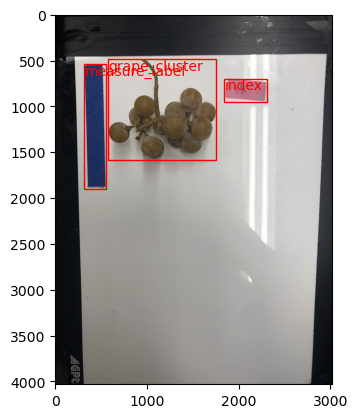

<Figure size 4000x4000 with 0 Axes>

In [5]:
detector.plt_all_boxes(image_path, box_dict)

# Visualization Tools

In [6]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_anns(anns):
    if len(anns) == 0:
        return

    # Convert the tensors to numpy arrays and sort them
    np_anns = [ann.numpy() for ann in anns]
    sorted_anns = sorted(np_anns, key=lambda x: np.sum(x), reverse=True)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Initialize an image with transparency
    img = np.ones((sorted_anns[0].shape[0], sorted_anns[0].shape[1], 4))
    img[:, :, 3] = 0
    
    i = 0
    for ann in sorted_anns:
        # Create a random color mask with transparency
        color_mask = np.concatenate([np.random.random(3), [0.35]])

        # Apply the mask to the annotation areas
        img[ann.astype(bool)] = color_mask
        
        # add text
        text = str(i)
        ys, xs = np.where(ann)
        centroid = (np.mean(xs), np.mean(ys))
        ax.scatter(centroid[0], centroid[1], color='green', marker='.', s=50, edgecolor='white', linewidth=1.25)    
        # ax.text(centroid[0], centroid[1], text, color='white', ha='center', va='center')
        # i += 1
        
    ax.imshow(img)

# Segmentation

In [28]:
from tools.Segmentator import Segmentator
import numpy as np
import torch

In [18]:
import cv2

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

NameError: name 'image_path' is not defined

In [10]:
box_dict['grape_cluster']

array([     579.34,      478.78,      1758.6,      1583.8], dtype=float32)

In [21]:
grape_bbox = box_dict['grape_cluster']
index_bbox = box_dict['index']
measure_bbox = box_dict['measure_label']

In [12]:
GrapeSegmenter = Segmentator(model_path='./FastSAM/weights/FastSAM-x.pt', DEVICE='cpu')
prompt_process= GrapeSegmenter.start(image_path)


image 1/1 E:\Dev\GrapeYOLO\samples\1A_back_grape.jpg: 1024x768 24 objects, 1981.5ms
Speed: 9.0ms preprocess, 1981.5ms inference, 845.4ms postprocess per image at shape (1, 3, 1024, 1024)


### 长度衡量系数
使用opencv里面的轮廓检测方法去做

In [63]:
local_ann = GrapeSegmenter.seg_with_bbox(prompt_process, list(box_dict['grape_cluster']))
type(local_ann)

numpy.ndarray

In [3]:
# [     318.09,      536.22,       555.9,      1896.2]
(536.22 + 1896.2)/2

1216.21

In [14]:
import tools.utils as utils

a = utils.cal_measure_coefficient('samples/1A_back_grape.jpg', [     318.09,      536.22,       555.9,      1896.2])

a

NameError: name 'np' is not defined

In [4]:
import cv2
import numpy as np

def resize_image(image, max_width=800, max_height=600):
    """调整图像大小以适应最大宽度和高度"""
    original_height, original_width = image.shape[:2]
    scale_width = max_width / original_width
    scale_height = max_height / original_height
    scale = min(scale_width, scale_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# 读取图像
image = cv2.imread('samples/1A_back_grape.jpg')

# 将图像转换为灰度图
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# 应用阈值化突出目标
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 查找轮廓
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



x, y = 436, 1216
x, y = int(x), int(y)
print(x, y)

# 选择最接近质心的轮廓
closest_contour = None
min_dist = float('inf')
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        dist = np.sqrt((cx - x) ** 2 + (cy - y) ** 2)
        if dist < min_dist:
            min_dist = dist
            closest_contour = contour

# 检查是否找到了最接近的轮廓
if closest_contour is not None:
    # 在原始图像上画出轮廓
    cv2.drawContours(image, [closest_contour], -1, (0, 255, 0), 3)

    # 获取最小包围矩形
    rect = cv2.minAreaRect(closest_contour)
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    cv2.drawContours(image, [box], 0, (0, 0, 255), 10)
    
    # 计算矩形的宽度和高度
    width = np.linalg.norm(box[0] - box[1])
    height = np.linalg.norm(box[1] - box[2])
    print(f"Width: {width}, Height: {height}")

# 在图像上标记质心点及其坐标
cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
cv2.putText(image, f"({x}, {y})", (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# 调整图像大小并显示
resized_image = resize_image(image)
cv2.imshow('Resized Image with Closest Contour', resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


436 1216
Width: 204.08821622033938, Height: 1347.6546293468516


### 把葡萄抠出来

In [70]:
# [     318.09,      536.22,       555.9,      1896.2]

import cv2

# 加载图像
image = cv2.imread(image_path)

# 定义bbox的坐标，格式为 [x1, y1, x2, y2]
bbox = list(box_dict['grape_cluster'])
# 使用数组切片操作提取bbox区域
x1, y1, x2, y2 = bbox
cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
# 显示裁剪后的图像
cv2.imwrite('cropped_image.jpg', cropped_image)

from IPython.display import Image, display

display(Image(filename='cropped_image.jpg'))

True

### 葡萄切割优化

In [19]:
GrapeSegmenter = Segmentator(model_path='./FastSAM/weights/FastSAM-x.pt', DEVICE='cpu')
prompt_process= GrapeSegmenter.start('./cropped_image.jpg')
ann_everything = GrapeSegmenter.seg_everything(prompt_process)
len(ann_everything)


image 1/1 E:\Dev\GrapeYOLO\cropped_image.jpg: 960x1024 19 objects, 2617.4ms
Speed: 15.0ms preprocess, 2617.4ms inference, 96.5ms postprocess per image at shape (1, 3, 1024, 1024)


19

In [15]:
print(ann_everything)

NameError: name 'ann_everything' is not defined

In [21]:
# input_box = np.array(grape_bbox)
image = cv2.imread('./cropped_image.jpg')
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(ann_everything)
# show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 

'''
berry per length
circle marker major minor axis


where the cluster
compactness
disease prediction model
'''

NameError: name 'plt' is not defined

## Segment measure label

In [25]:
measure_ann = GrapeSegmenter.seg_with_bbox(prompt_process, measure_bbox)
len(measure_ann)

1

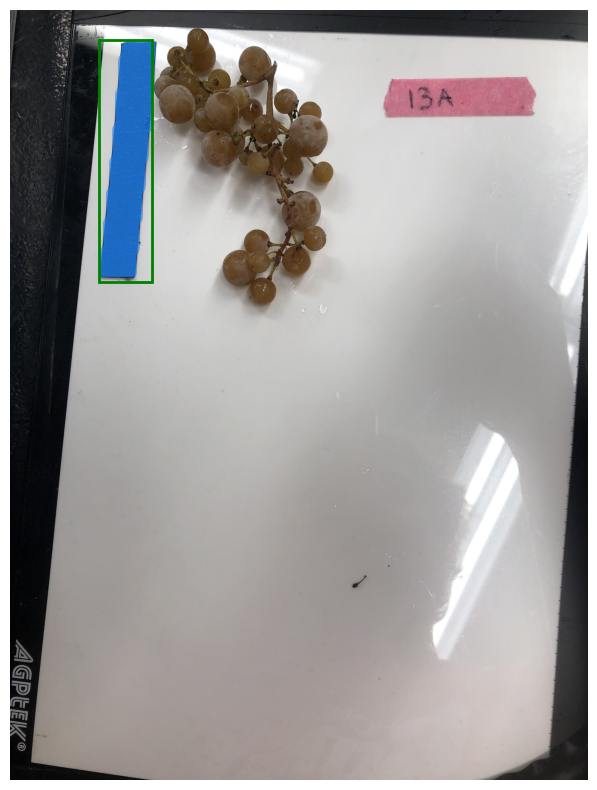

In [26]:
input_box = np.array(measure_bbox)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(measure_ann, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 

## Segment Index

In [27]:
index_ann = GrapeSegmenter.seg_with_bbox(prompt_process, index_bbox)
len(index_ann)

1

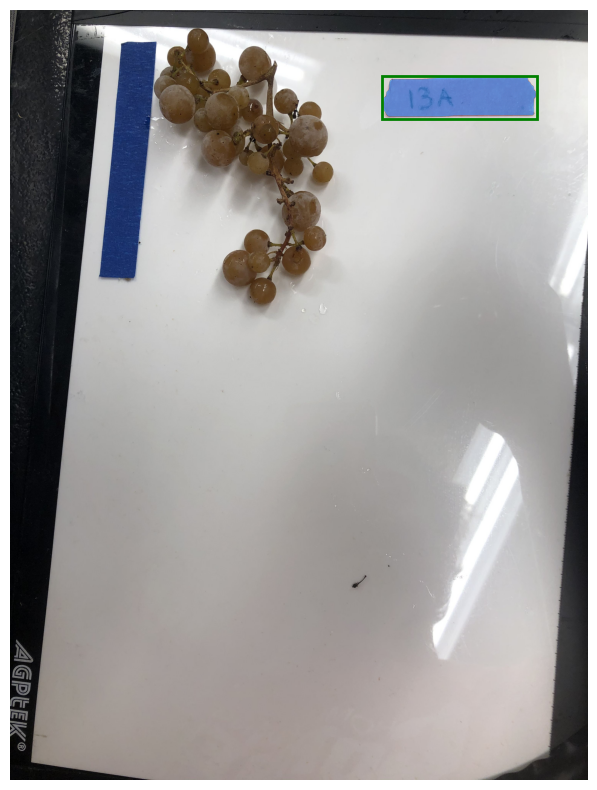

In [28]:
input_box = np.array(index_bbox)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(index_ann, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 